### Проект 5 [Одобрение кредита]

Вам предоставляется набор данных. Набор данных уже разделен на ```train_data.csv``` и ```test_data.csv```.

**Цель:** построить модели для **одобрения кредита** (```"Credit Default"```).

Пожалуйста, включите подробные объяснения следующих шагов:

1. Очистка, предварительная обработка данных, и Exploratory Data Analysis

2. Обучение и проверка моделей.

3. Сравнение моделей на основе метрик классификации: ```F-score```, ```Precision```, ```Recall```.

**Примечание:** вам **рекомендуется** искать так же другие алгоритмы машинного обучения в Интернете (не ограничиваясь материалом курса), но вы должны изучить и понять эти алгоритмы. Вы не можете удалить ни одну строку в файле ```test_data.csv```.

***
# **1. ОЧИСТКА ДАННЫХ**

## **1.1.  БЛОК ИМПОРТА**

In [103]:
from pandas import read_csv, options, set_option, DataFrame, Series, get_dummies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from os import path, mkdir

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# модули обучения и построения моделей
from src.functions import *


## **1.2. ЗАГРУЗКА ДАННЫХ**

In [104]:
# новые названия столбцов
new_column_names = ['homeownership',                    #'Home Ownership',
                    'annual_income',                    #'Annual Income',
                    'curjobyears',                      #'Years in current job',
                    'tax_liens',                        #'Tax Liens',
                    'open_accounts',                    #'Number of Open Accounts',
                    'credit_history_years',             #'Years of Credit History',
                    'max_open_credit',                  #'Maximum Open Credit',
                    'credit_problems',                  #'Number of Credit Problems',
                    'last_delinquent_monthes',          #'Months since last delinquent',
                    'bankruptcies',                     #'Bankruptcies',
                    'purpose',                          #'Purpose',
                    'term',                             #'Term',
                    'current_loan',                     #'Current Loan Amount',
                    'current_balance',                  #'Current Credit Balance',
                    'monthly_debt',                     #'Monthly Debt',
                    'credit_score',                     #'Credit Score',
                    'credit_default'                    #'Credit Default'
                    ]
# присвоение данных
df_train = set_numbercolumn(df=read_csv(filepath_or_buffer="./train_data.csv",
                                        header=0, names=new_column_names), columnname="Id")
df_test  = set_numbercolumn(df=read_csv(filepath_or_buffer="./test_data.csv",
                                        header=0, names=new_column_names), columnname="Id")

***
## **1.3. ИССЛЕДОВАНИЕ ВВОДНЫХ ДАННЫХ**

### **1.3.1. `Тренировочные данные` 'train'**

1. При визуальном осмотре файла аномалий в виде непонятных и "грязных" данных не выявлено.
2. Вывод данных на экран и первичный сбор информации в выборке выявил отсутствующих значений (NaN).
3. Замечен широкий диапазон размерностей параметров, что, вероятно, потребует стандартизацию данных.
4. Присутствуют категорийные параметры, требующие кодирования значений в цифровой вид.
5. Есть длинные названия столбцов, требущие сокращения для быстрой обработки данных.
6. Ход решения указан в соотвествующих шагах обработки выборки.

In [105]:
# Установка параметра display.max_columns в None
set_option('display.max_columns', None)

In [106]:
# тренировочная выборка
df_train

homeownership  annual_income curjobyears  tax_liens  open_accounts  \
Id                                                                         
1     Home Mortgage            NaN   10+ years    0.00000       10.00000   
2              Rent   767904.00000      1 year    0.00000        9.00000   
3          Own Home            NaN     9 years    0.00000       14.00000   
4     Home Mortgage  1267395.00000     3 years    0.00000       11.00000   
5              Rent  1813493.00000     7 years    0.00000       19.00000   
...             ...            ...         ...        ...            ...   
6746  Home Mortgage   840902.00000      1 year    0.00000        9.00000   
6747  Home Mortgage            NaN   10+ years    0.00000        8.00000   
6748  Home Mortgage  1414892.00000     8 years    0.00000       28.00000   
6749  Home Mortgage  1896333.00000     3 years    0.00000        7.00000   
6750       Own Home            NaN     7 years    0.00000       25.00000   

      credit_history_years  max_open_credit  credit_problems  \
Id                                                             
1                 21.80000     267762.00000          0.00000   
2                 15.40000     275528.00000          0.00000   
3                 27.10000    1635590.00000          1.00000   
4                 11.80000     137676.00000          1.00000   
5                 14.00000     501556.00000          0.00000   
...                    ...              ...              ...   
6746              21.30000     543268.00000          0.00000   
6747              11.10000     649462.00000          0.00000   
6748              15.20000    1240426.00000          0.00000   
6749              12.90000     544632.00000          0.00000   
6750              27.80000     925650.00000          0.00000   

      last_delinquent_monthes  bankruptcies             purpose        term  \
Id                                                                            
1                         NaN       0.00000  debt consolidation  Short Term   
2                    73.00000       0.00000  debt consolidation  Short Term   
3                         NaN       0.00000  debt consolidation  Short Term   
4                    61.00000       0.00000   home improvements  Short Term   
5                     6.00000       0.00000  debt consolidation  Short Term   
...                       ...           ...                 ...         ...   
6746                 25.00000       0.00000  debt consolidation   Long Term   
6747                      NaN       0.00000  debt consolidation  Short Term   
6748                      NaN       0.00000  debt consolidation  Short Term   
6749                      NaN       0.00000  debt consolidation   Long Term   
6750                 33.00000       0.00000       medical bills  Short Term   

       current_loan  current_balance  monthly_debt  credit_score  \
Id                                                                 
1      193358.00000     140372.00000   19404.00000           NaN   
2      222288.00000     168226.00000   18302.00000     718.00000   
3      433268.00000    1017032.00000   15295.00000           NaN   
4    99999999.00000      34124.00000   25559.00000     719.00000   
5      265232.00000     114779.00000   23877.00000     713.00000   
...             ...              ...           ...           ...   
6746   227722.00000     436810.00000   20041.00000     670.00000   
6747   321750.00000     288857.00000    7100.00000           NaN   
6748 99999999.00000     325660.00000   33839.00000     738.00000   
6749   516648.00000     408747.00000   23072.00000     719.00000   
6750   220924.00000     396511.00000   20180.00000           NaN   

      credit_default  
Id                    
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
...              ...  
6746               0  
6747               0  
6748               0  
6749              

#### **1.3.1.1. Статистика по типам данным**

Требуется приведение типов для некоторых столбцов. Для этого сделано изучение данных доступными способами.

In [107]:
# статистика по типам данным
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6750 entries, 1 to 6750
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   homeownership            6750 non-null   object 
 1   annual_income            5350 non-null   float64
 2   curjobyears              6418 non-null   object 
 3   tax_liens                6750 non-null   float64
 4   open_accounts            6750 non-null   float64
 5   credit_history_years     6750 non-null   float64
 6   max_open_credit          6750 non-null   float64
 7   credit_problems          6750 non-null   float64
 8   last_delinquent_monthes  3075 non-null   float64
 9   bankruptcies             6738 non-null   float64
 10  purpose                  6750 non-null   object 
 11  term                     6750 non-null   object 
 12  current_loan             6750 non-null   float64
 13  current_balance          6750 non-null   float64
 14  monthly_debt            

In [108]:
format_in_dataframe(5)
df_train.describe()

annual_income  tax_liens  open_accounts  credit_history_years  \
count     5350.00000 6750.00000     6750.00000            6750.00000   
mean   1368477.94411    0.02933       11.12904              18.32539   
std     844312.84951    0.26895        4.90274               7.07616   
min     164597.00000    0.00000        2.00000               4.00000   
25%     845989.25000    0.00000        8.00000              13.50000   
50%    1170913.00000    0.00000       10.00000              17.00000   
75%    1643780.25000    0.00000       14.00000              21.80000   
max    9338880.00000    7.00000       43.00000              57.70000   

       max_open_credit  credit_problems  last_delinquent_monthes  \
count       6750.00000       6750.00000               3075.00000   
mean      904896.78726          0.16978                 34.73789   
std     16226437.59089          0.49706                 21.73226   
min            0.00000          0.00000                  0.00000   
25%       279537.50000          0.00000                 16.00000   
50%       477114.00000          0.00000                 32.00000   
75%       790625.00000          0.00000                 50.00000   
max   1304726170.00000          7.00000                118.00000   

       bankruptcies   current_loan  current_balance  monthly_debt  \
count    6738.00000     6750.00000       6750.00000    6750.00000   
mean        0.11843 11873069.22919     288831.89748   18339.61081   
std         0.34834 31926402.07677     321473.41650   11930.62843   
min         0.00000    11242.00000          0.00000       0.00000   
25%         0.00000   179619.00000     112674.75000   10068.75000   
50%         0.00000   309936.00000     208449.00000   16161.00000   
75%         0.00000   519475.00000     359883.75000   23900.50000   
max         4.00000 99999999.00000    6506797.00000  136679.00000   

       credit_score  credit_default  
count    5350.00000      6750.00000  
mean     1147.82523         0.28519  
std      1599.62824         0.45154  
min       585.00000         0.00000  
25%       711.00000         0.00000  
50%       731.00000         0.00000  
75%       743.00000         1.00000  
max      7510.00000         1.00000

Большие значения **std** говорят о большом разбросе данных.

In [109]:
df_train.std(numeric_only=True).sort_values(ascending=False)

current_loan              31926402.07677
max_open_credit           16226437.59089
annual_income               844312.84951
current_balance             321473.41650
monthly_debt                 11930.62843
credit_score                  1599.62824
last_delinquent_monthes         21.73226
credit_history_years             7.07616
open_accounts                    4.90274
credit_problems                  0.49706
credit_default                   0.45154
bankruptcies                     0.34834
tax_liens                        0.26895
dtype: float64

##### **1.3.1.1.1. Проверка распределения данных в выборках**

In [ ]:
df_train["credit_default"].value_counts(normalize=True)

0   0.71481
1   0.28519
Name: credit_default, dtype: float64

In [ ]:
df_test["credit_default"].value_counts(normalize=True)

0   0.74933
1   0.25067
Name: credit_default, dtype: float64

#### **1.3.1.2. Пустые значения в таблице**

##### **1.3.1.2.1. Определение количества и названия пустых значений**

Отсутствующие данные обнаружены у пяти праметров тренировочной выборки.

In [110]:
# определение количества пустых значений
df_train.isna().sum()

homeownership                 0
annual_income              1400
curjobyears                 332
tax_liens                     0
open_accounts                 0
credit_history_years          0
max_open_credit               0
credit_problems               0
last_delinquent_monthes    3675
bankruptcies                 12
purpose                       0
term                          0
current_loan                  0
current_balance               0
monthly_debt                  0
credit_score               1400
credit_default                0
dtype: int64

In [111]:
# спсиок столбцов наличием 'NaN'
na_col_list = df_train.columns[df_train.isna().any()].tolist()
df_train[na_col_list]

annual_income curjobyears  last_delinquent_monthes  bankruptcies  \
Id                                                                       
1               NaN   10+ years                      NaN       0.00000   
2      767904.00000      1 year                 73.00000       0.00000   
3               NaN     9 years                      NaN       0.00000   
4     1267395.00000     3 years                 61.00000       0.00000   
5     1813493.00000     7 years                  6.00000       0.00000   
...             ...         ...                      ...           ...   
6746   840902.00000      1 year                 25.00000       0.00000   
6747            NaN   10+ years                      NaN       0.00000   
6748  1414892.00000     8 years                      NaN       0.00000   
6749  1896333.00000     3 years                      NaN       0.00000   
6750            NaN     7 years                 33.00000       0.00000   

      credit_score  
Id                  
1              NaN  
2        718.00000  
3              NaN  
4        719.00000  
5        713.00000  
...            ...  
6746     670.00000  
6747           NaN  
6748     738.00000  
6749     719.00000  
6750           NaN  

[6750 rows x 5 columns]

##### **1.3.1.3.2. Анализ отсутствующих значений**

В выборке нет отрицательных значений и тип данных 'float', поэтому есть возможность оставить значения 'NaN' без дополнительного шифрования (например, перевод в '-1'). Кодирование таких значений будет сделано на общем этапе группировки данных.

Столбцы:
1. 'curjobyears'
2. 'bankruptcies'

**не требуют группировки**.

In [112]:
# проверка на типы данных внутри каждого столбца с 'NaN'
print("Столбец", "Тип данных","Уникальные значения", "Количество", "="*100, sep=" => ")
for val in na_col_list:
    print(val, df_train[val].dtype, df_train[val].unique(), len(df_train[val].unique()),sep=" => ")
    print()

Столбец => Тип данных => Уникальные значения => Количество => ====================================================================================================
annual_income => float64 => [     nan  767904. 1267395. ...  840902. 1414892. 1896333.] => 4973

curjobyears => object => ['10+ years' '1 year' '9 years' '3 years' '7 years' nan '8 years'
 '6 years' '< 1 year' '4 years' '5 years' '2 years'] => 12

last_delinquent_monthes => float64 => [ nan  73.  61.   6.  11.  22.  18.  12.  13.  47.  29.  42.   8.  36.
  24.  28.  54.  56.  15.  75.  10.  64.   7.  45.  39.  26.  44.  38.
  33.  69.  14.  68.  30.  50.  25.  23.  40.  70.  49.  67.  37.  48.
  65.  41.  17.   3.  20.  16.  31.  71.  74.   1.  78.  60.   2.  66.
  72.   9.  63.   5.  59.  34.  62.  57.  82.  46.   4.  19.  58. 118.
  53.  43.  27.   0.  76.  52.  80.  32.  81.  55.  35.  51.  77.  21.
  79.  84.  92.  86.  83.  91.] => 90

bankruptcies => float64 => [ 0.  1.  2.  3. nan  4.] => 6

credit_score => float64 => 

In [113]:
# обработка данных типа 'object'
df_train = cleared_data(df=df_train)
df_train

homeownership <class 'str'>
curjobyears <class 'str'>
purpose <class 'str'>
term <class 'str'>


homeownership  annual_income curjobyears  tax_liens  open_accounts  \
Id                                                                        
1     HomeMortgage            NaN    10+years    0.00000       10.00000   
2             Rent   767904.00000       1year    0.00000        9.00000   
3          OwnHome            NaN      9years    0.00000       14.00000   
4     HomeMortgage  1267395.00000      3years    0.00000       11.00000   
5             Rent  1813493.00000      7years    0.00000       19.00000   
...            ...            ...         ...        ...            ...   
6746  HomeMortgage   840902.00000       1year    0.00000        9.00000   
6747  HomeMortgage            NaN    10+years    0.00000        8.00000   
6748  HomeMortgage  1414892.00000      8years    0.00000       28.00000   
6749  HomeMortgage  1896333.00000      3years    0.00000        7.00000   
6750       OwnHome            NaN      7years    0.00000       25.00000   

      credit_history_years  max_open_credit  credit_problems  \
Id                                                             
1                 21.80000     267762.00000          0.00000   
2                 15.40000     275528.00000          0.00000   
3                 27.10000    1635590.00000          1.00000   
4                 11.80000     137676.00000          1.00000   
5                 14.00000     501556.00000          0.00000   
...                    ...              ...              ...   
6746              21.30000     543268.00000          0.00000   
6747              11.10000     649462.00000          0.00000   
6748              15.20000    1240426.00000          0.00000   
6749              12.90000     544632.00000          0.00000   
6750              27.80000     925650.00000          0.00000   

      last_delinquent_monthes  bankruptcies            purpose       term  \
Id                                                                          
1                         NaN       0.00000  debtconsolidation  ShortTerm   
2                    73.00000       0.00000  debtconsolidation  ShortTerm   
3                         NaN       0.00000  debtconsolidation  ShortTerm   
4                    61.00000       0.00000   homeimprovements  ShortTerm   
5                     6.00000       0.00000  debtconsolidation  ShortTerm   
...                       ...           ...                ...        ...   
6746                 25.00000       0.00000  debtconsolidation   LongTerm   
6747                      NaN       0.00000  debtconsolidation  ShortTerm   
6748                      NaN       0.00000  debtconsolidation  ShortTerm   
6749                      NaN       0.00000  debtconsolidation   LongTerm   
6750                 33.00000       0.00000       medicalbills  ShortTerm   

       current_loan  current_balance  monthly_debt  credit_score  \
Id                                                                 
1      193358.00000     140372.00000   19404.00000           NaN   
2      222288.00000     168226.00000   18302.00000     718.00000   
3      433268.00000    1017032.00000   15295.00000           NaN   
4    99999999.00000      34124.00000   25559.00000     719.00000   
5      265232.00000     114779.00000   23877.00000     713.00000   
...             ...              ...           ...           ...   
6746   227722.00000     436810.00000   20041.00000     670.00000   
6747   321750.00000     288857.00000    7100.00000           NaN   
6748 99999999.00000     325660.00000   33839.00000     738.00000   
6749   516648.00000     408747.00000   23072.00000     719.00000   
6750   220924.00000     396511.00000   20180.00000           NaN   

      credit_default  
Id                    
1                  0  
2                  0  
3                  0  
4                  0  
5                  0  
...              ...  
6746               0  
6747               0  
6748               0  
6749               0  
6750               0  

[6750 row

In [114]:
# список столбцов типа 'object'
column_object_list = df_train.select_dtypes("object").columns.to_list()
column_object_list

['homeownership', 'curjobyears', 'purpose', 'term']

***
#### **1.4. КОРРЕЛЯЦИЯ**

На этом этапе идёт проверка взаимного влияния параметров на 'credit_default'.

Значения коэффициентов корреляции очень низки для всх параметров. Такая же матрица строилась для других вариантов группировок значений столбцов(параметров), но там так же не было замечено значительных изменений по стравнению с этой исходной таблицей.

В данный расчёт так же не вошли около 10 различных комбинаций сочетаний и группировки постолбцовых значений, по причине низких показателей 'f1 score' (ниже 0.19).

Этот раздел никак не влияет на дальнейшие расчёты и оставлен в качестве примера одного из многочисленных этапов исследований поведения моделей.

##### **1.4.1.1. Визуализация корреляции**

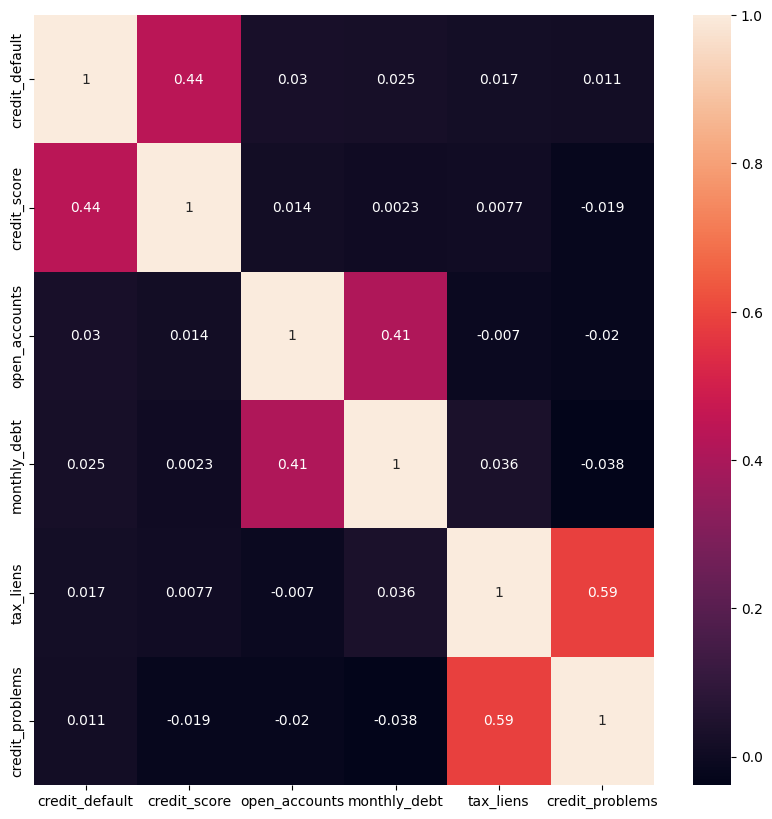

In [115]:
# визуализация корреляции тренировочной выборки
df_train_corr_0 = df_train.corr(numeric_only=True)
# наиболее коррелированные параметры с 'charges'
important_list_0 = df_train_corr_0["credit_default"].nlargest(5+1).index[0:].values.tolist()

# визуализация корреляции выборки 'train'
fig, ax = plt.subplots(figsize=(10,10))
df_corr_large_0 = df_train[important_list_0].corr()
sns.heatmap(data=df_corr_large_0, annot=True, ax=ax);

Этот код остался от параллельных исследований (был худший результат f1 score)

In [116]:
# df_train_corr = df_FINAL_train.corr()
# # наиболее коррелированные параметры с 'charges'
# important_list = df_train_corr["credit_default"].nlargest(10+1).index[0:].values.tolist()

# # визуализация корреляции выборки 'train'
# fig, ax = plt.subplots(figsize=(5,3))
# df_corr_large = df_FINAL_train[important_list].corr()
# sns.heatmap(data=df_corr_large, annot=True, ax=ax);

##### **1.4.2. Проверка на уникальность данных внутри каждого столбца типа 'object'**

Не все варианты одинаково читаемо показывают такие значения. Поэтому написан код для улучшенного анализа данных

In [117]:
# проверка на уникальность данных внутри каждого столбца типа 'object'
print("Столбец", "Тип данных","Уникальные значения", "Количество", "="*100, sep=" => ")
for val in column_object_list:
    print(val, df_train[val].dtype, df_train[val].unique(), len(df_train[val].unique()),sep=" => ")
    print()

Столбец => Тип данных => Уникальные значения => Количество => ====================================================================================================
homeownership => object => ['HomeMortgage' 'Rent' 'OwnHome' 'HaveMortgage'] => 4

curjobyears => object => ['10+years' '1year' '9years' '3years' '7years' 'nan' '8years' '6years'
 '<1year' '4years' '5years' '2years'] => 12

purpose => object => ['debtconsolidation' 'homeimprovements' 'buyhouse' 'takeatrip' 'other'
 'businessloan' 'wedding' 'moving' 'medicalbills' 'majorpurchase'
 'buyacar' 'vacation' 'educationalexpenses' 'smallbusiness'
 'renewableenergy'] => 15

term => object => ['ShortTerm' 'LongTerm'] => 2



In [118]:
# уникальные значения
df_train.select_dtypes("object").value_counts()

homeownership  curjobyears  purpose            term     
HomeMortgage   10+years     debtconsolidation  ShortTerm    672
Rent           10+years     debtconsolidation  ShortTerm    406
HomeMortgage   10+years     debtconsolidation  LongTerm     368
Rent           2years       debtconsolidation  ShortTerm    232
               <1year       debtconsolidation  ShortTerm    191
                                                           ... 
OwnHome        7years       homeimprovements   ShortTerm      1
                            medicalbills       ShortTerm      1
                            other              ShortTerm      1
                            smallbusiness      LongTerm       1
Rent           nan          takeatrip          ShortTerm      1
Length: 429, dtype: int64

In [119]:
# список всех столбцов таблицы
total_columnn_list = df_train.columns.to_list()

# контейнеры для сортировки
noencode_list = []
forencode_list = []
count_forencode_dict = {}

# столбцы, где не требуется приводить значения к бинарному типу
for val in total_columnn_list:
    un = df_train[val].unique()
    if len(un) == 2:
        print(f"{val} = {len(un)}", "=>",un)
        noencode_list.append(val)
        count_forencode_dict[val] = len(un)
    
    # список столбцов для кодирования
    else:
        print(f"=== {val} = {len(un)}")
        forencode_list.append(val)
        count_forencode_dict[val] = len(un)

print("="*50)
print("\nСписок столбцов где НЕ требуется кодирование\n", noencode_list)
print("="*50)

print("\nСписок столбцов где требуется кодирование\n", forencode_list)
print("="*50)

print("\nСписок количества категорий для кодирования\n", sorted(count_forencode_dict.values()))

=== homeownership = 4
=== annual_income = 4973
=== curjobyears = 12
=== tax_liens = 8
=== open_accounts = 38
=== credit_history_years = 403
=== max_open_credit = 6307
=== credit_problems = 8
=== last_delinquent_monthes = 90
=== bankruptcies = 6
=== purpose = 15
term = 2 => ['ShortTerm' 'LongTerm']
=== current_loan = 4927
=== current_balance = 6006
=== monthly_debt = 6108
=== credit_score = 261
credit_default = 2 => [0 1]

Список столбцов где НЕ требуется кодирование
 ['term', 'credit_default']

Список столбцов где требуется кодирование
 ['homeownership', 'annual_income', 'curjobyears', 'tax_liens', 'open_accounts', 'credit_history_years', 'max_open_credit', 'credit_problems', 'last_delinquent_monthes', 'bankruptcies', 'purpose', 'current_loan', 'current_balance', 'monthly_debt', 'credit_score']

Список количества категорий для кодирования
 [2, 2, 4, 6, 8, 8, 12, 15, 38, 90, 261, 403, 4927, 4973, 6006, 6108, 6307]


Количество категорий относительно невелико, поэтому можно сделать поверхностный визуальный обзор параметров для разбиения на группы. Для этого делается изучение данных столбцов с последующим принятием решения каким способом сделать при необходимости кодирование данных.

In [120]:
# 'float'
for val in forencode_list:
    if df_train[val].dtype != np.int64:
        unik = df_train[val].sort_values().unique()
        print(val, unik, len(unik), sep=" => ")

homeownership => ['HaveMortgage' 'HomeMortgage' 'OwnHome' 'Rent'] => 4
annual_income => [ 164597.  175845.  177251. ... 8923844. 9338880.      nan] => 4973
curjobyears => ['10+years' '1year' '2years' '3years' '4years' '5years' '6years' '7years'
 '8years' '9years' '<1year' 'nan'] => 12
tax_liens => [0. 1. 2. 3. 4. 5. 6. 7.] => 8
open_accounts => [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 37. 38.
 41. 43.] => 38
credit_history_years => [ 4.   4.3  4.5  4.7  4.8  4.9  5.   5.1  5.2  5.4  5.5  5.6  5.7  5.8
  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2
  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6
  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.
 10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4
 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8
 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 1

In [121]:
# список колонок типа 'int64'
number_col_list = df_train[forencode_list].select_dtypes(exclude="object").columns.to_list()
number_col_list

['annual_income',
 'tax_liens',
 'open_accounts',
 'credit_history_years',
 'max_open_credit',
 'credit_problems',
 'last_delinquent_monthes',
 'bankruptcies',
 'current_loan',
 'current_balance',
 'monthly_debt',
 'credit_score']

In [122]:
# приведение типов в тестовой выборке
df_test = cleared_data(df=df_test)

homeownership <class 'str'>
curjobyears <class 'str'>
purpose <class 'str'>
term <class 'str'>


##### **1.4.3. Проверка результатов обработки выборок после приведения типов**

In [123]:
# определение разности в параметрах столбцов типа 'object'
diff_parameters(df_train=df_train, df_test=df_test, column_object_list=column_object_list)

['renewableenergy', 'educationalexpenses']

In [124]:
# словарь с именами столбцов и их значениями
df_encoded_train, df_encoded_test = encode_features(df_train=df_train, df_test=df_test)

['purpose_educationalexpenses' 'purpose_renewableenergy'] []


In [125]:
# нехватка столбцов (в ответе должно быть пусто "[]", иначе что-то было упущено)
[val for val in df_encoded_train.columns if val not in df_encoded_test.columns]

[]

In [126]:
# столбцы выборки после обработки
df_encoded_test.columns

Index(['annual_income', 'tax_liens', 'open_accounts', 'credit_history_years',
       'max_open_credit', 'credit_problems', 'last_delinquent_monthes',
       'bankruptcies', 'current_loan', 'current_balance', 'monthly_debt',
       'credit_score', 'credit_default', 'homeownership_HaveMortgage',
       'homeownership_HomeMortgage', 'homeownership_OwnHome',
       'homeownership_Rent', 'curjobyears_10+years', 'curjobyears_1year',
       'curjobyears_2years', 'curjobyears_3years', 'curjobyears_4years',
       'curjobyears_5years', 'curjobyears_6years', 'curjobyears_7years',
       'curjobyears_8years', 'curjobyears_9years', 'curjobyears_<1year',
       'curjobyears_nan', 'purpose_businessloan', 'purpose_buyacar',
       'purpose_buyhouse', 'purpose_debtconsolidation',
       'purpose_homeimprovements', 'purpose_majorpurchase',
       'purpose_medicalbills', 'purpose_moving', 'purpose_other',
       'purpose_smallbusiness', 'purpose_takeatrip', 'purpose_vacation',
       'purpose_wedding', 

In [127]:
# тренировочная выборка после обработки
df_encoded_train

annual_income  tax_liens  open_accounts  credit_history_years  \
Id                                                                    
1               NaN    0.00000       10.00000              21.80000   
2      767904.00000    0.00000        9.00000              15.40000   
3               NaN    0.00000       14.00000              27.10000   
4     1267395.00000    0.00000       11.00000              11.80000   
5     1813493.00000    0.00000       19.00000              14.00000   
...             ...        ...            ...                   ...   
6746   840902.00000    0.00000        9.00000              21.30000   
6747            NaN    0.00000        8.00000              11.10000   
6748  1414892.00000    0.00000       28.00000              15.20000   
6749  1896333.00000    0.00000        7.00000              12.90000   
6750            NaN    0.00000       25.00000              27.80000   

      max_open_credit  credit_problems  last_delinquent_monthes  bankruptcies  \
Id                                                                              
1        267762.00000          0.00000                      NaN       0.00000   
2        275528.00000          0.00000                 73.00000       0.00000   
3       1635590.00000          1.00000                      NaN       0.00000   
4        137676.00000          1.00000                 61.00000       0.00000   
5        501556.00000          0.00000                  6.00000       0.00000   
...               ...              ...                      ...           ...   
6746     543268.00000          0.00000                 25.00000       0.00000   
6747     649462.00000          0.00000                      NaN       0.00000   
6748    1240426.00000          0.00000                      NaN       0.00000   
6749     544632.00000          0.00000                      NaN       0.00000   
6750     925650.00000          0.00000                 33.00000       0.00000   

       current_loan  current_balance  monthly_debt  credit_score  \
Id                                                                 
1      193358.00000     140372.00000   19404.00000           NaN   
2      222288.00000     168226.00000   18302.00000     718.00000   
3      433268.00000    1017032.00000   15295.00000           NaN   
4    99999999.00000      34124.00000   25559.00000     719.00000   
5      265232.00000     114779.00000   23877.00000     713.00000   
...             ...              ...           ...           ...   
6746   227722.00000     436810.00000   20041.00000     670.00000   
6747   321750.00000     288857.00000    7100.00000           NaN   
6748 99999999.00000     325660.00000   33839.00000     738.00000   
6749   516648.00000     408747.00000   23072.00000     719.00000   
6750   220924.00000     396511.00000   20180.00000           NaN   

      credit_default  homeownership_HaveMortgage  homeownership_HomeMortgage  \
Id                                                                             
1                  0                           0                           1   
2                  0                           0                           0   
3                  0                           0                           0   
4                  0                           0                           1   
5                  0                           0                           0   
...              ...                         ...                         ...   
6746               0                           0                           1   
6747               0                           0                           1   
6748               0                           0                           1   
6749               0                           0                           1   
6750               0                           0                           0   

      homeownership_OwnHome  homeownership_Rent  curjobyears_10+years  \
Id                           

In [128]:
# тестовая выборка после обработки
df_encoded_test

annual_income  tax_liens  open_accounts  credit_history_years  \
Id                                                                   
1    1886510.00000    0.00000       13.00000              17.10000   
2     869877.00000    0.00000       16.00000              14.20000   
3              NaN    0.00000       13.00000              16.50000   
4    1125142.00000    0.00000       17.00000              16.50000   
5    1060998.00000    0.00000        7.00000              18.90000   
..             ...        ...            ...                   ...   
746   929860.00000    0.00000       12.00000              11.50000   
747  1597653.00000    0.00000       14.00000              14.80000   
748  1309955.00000    0.00000        8.00000               8.90000   
749            NaN    0.00000       20.00000               9.40000   
750  1168747.00000    0.00000       10.00000              19.70000   

     max_open_credit  credit_problems  last_delinquent_monthes  bankruptcies  \
Id                                                                             
1       552398.00000          0.00000                      NaN       0.00000   
2       657690.00000          0.00000                      NaN       0.00000   
3       638704.00000          0.00000                      NaN       0.00000   
4       570548.00000          0.00000                      NaN       0.00000   
5       379764.00000          0.00000                 27.00000       0.00000   
..               ...              ...                      ...           ...   
746     148434.00000          1.00000                      NaN       1.00000   
747     536052.00000          0.00000                      NaN       0.00000   
748     303358.00000          0.00000                      NaN       0.00000   
749     441716.00000          0.00000                  6.00000       0.00000   
750    1713074.00000          0.00000                      NaN       0.00000   

      current_loan  current_balance  monthly_debt  credit_score  \
Id                                                                
1     595782.00000     155059.00000   26097.00000     708.00000   
2     501380.00000     259008.00000   19645.00000     638.00000   
3     238150.00000     424745.00000   28795.00000           NaN   
4     393096.00000     284810.00000   22597.00000     676.00000   
5     268048.00000     188252.00000    5438.00000     739.00000   
..             ...              ...           ...           ...   
746   246554.00000      64866.00000   13948.00000     594.00000   
747 99999999.00000     343520.00000   30089.00000     746.00000   
748   224708.00000     191254.00000    7358.00000     741.00000   
749   334730.00000     263606.00000   25679.00000           NaN   
750   265826.00000     571083.00000   27173.00000     714.00000   

     credit_default  homeownership_HaveMortgage  homeownership_HomeMortgage  \
Id                                                                            
1                 0                           0                           1   
2                 1                           0                           0   
3                 0                           0                           1   
4                 0                           0                           1   
5                 0                           0                           1   
..              ...                         ...                         ...   
746               1                           0                           0   
747               0                           0                           1   
748               0                           0                           0   
749               0                           0                           0   
750               0                           0                           0   

     homeownership_OwnHome  homeownership_Rent  curjobyears_10+years  \
Id                                                                     
1        

Для дальнейшего построения моделей требуется кодирование. Набор данных в этих столбцах даёт возможность использовать `One-Hot Encoding`.

Из минусов такого кодирования следует:
- избыточность бинарных столбцов,
- затраты ресурсов компьютера и
- продолжительности обработки таких данных.

Далее будет сделана процедура масштабирования всех значений. Для этого написан ряд функций в соответствующих модулях проекта.

***
#### **1.5. Группировка данных**

##### **1.5.1. Визуализация для определения группировки данных**

На основе исследования графиков принято решение разбить данные из многочисленных значений целого типа на группы, выделенные на `boxplot` и `histplot` (шкала 'x').

Исследование на состав значений параметров ЦИФРОВОГО типа:
annual_income => [ 164597.  175845.  177251. ... 8923844. 9338880.      nan] => 4973 => Количество групп:  => 6
tax_liens => [0. 1. 2. 3. 4. 5. 6. 7.] => 8 => Количество групп:  => 6
open_accounts => [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 37. 38.
 41. 43.] => 38 => Количество групп:  => 7
credit_history_years => [ 4.   4.3  4.5  4.7  4.8  4.9  5.   5.1  5.2  5.4  5.5  5.6  5.7  5.8
  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2
  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3  8.4  8.5  8.6
  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.
 10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4
 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6 12.7 12.8
 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2
 14.3 14.4 14.5 14.6 14.7 14.8 1

max_open_credit => [0.00000000e+00 4.33400000e+03 6.62200000e+03 ... 2.64069960e+07
 2.65512874e+08 1.30472617e+09] => 6307 => Количество групп:  => 5
credit_problems => [0. 1. 2. 3. 4. 5. 6. 7.] => 8 => Количество групп:  => 6
last_delinquent_monthes => [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  86.  91.  92. 118.  nan] => 90 => Количество групп:  => 5
bankruptcies => [ 0.  1.  2.  3.  4. nan] => 6 => Количество групп:  => 7
current_loan => [1.1242000e+04 2.1472000e+04 2.1516000e+04 ... 7.8878800e+05 7.8903000e+05
 9.9999999e+07] => 4927 => Количество групп:  => 7
current_balance => [0.000000e+00 1.900

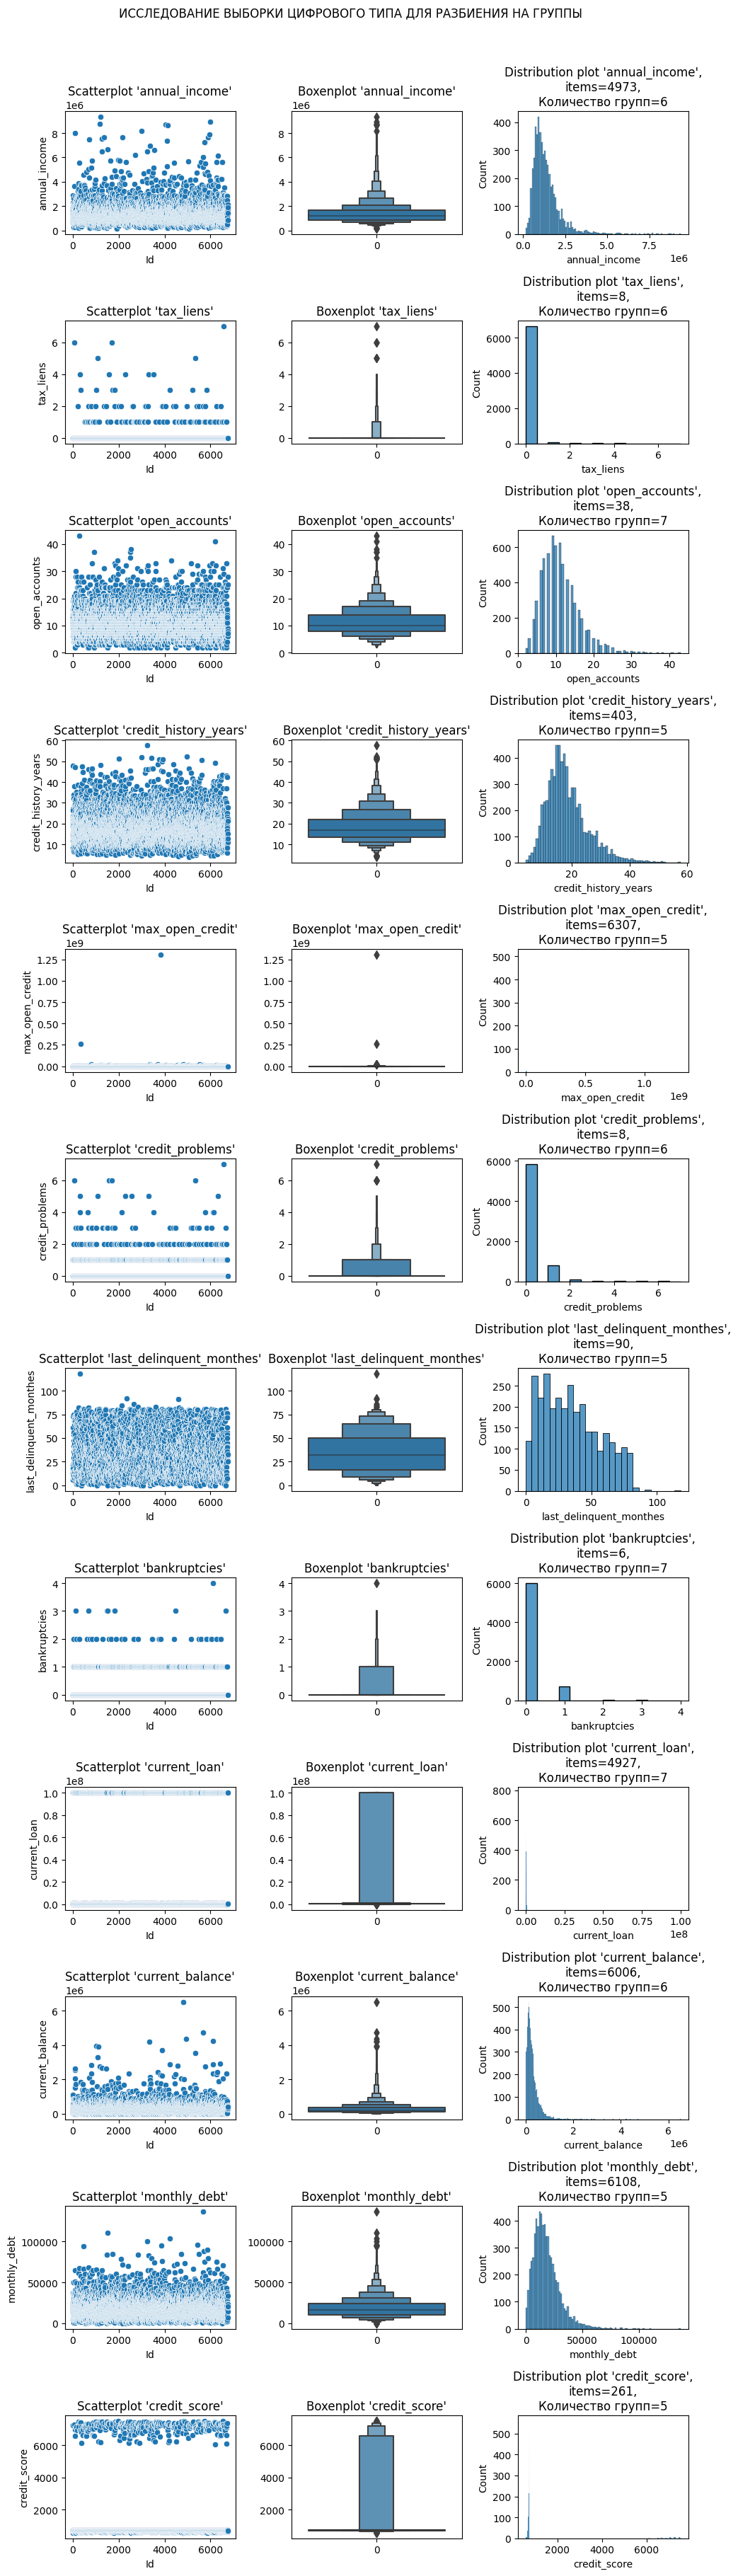

In [129]:
# словарь с данными для разбиения на группы
groups_int_dict = {}

# построение графиков и заполнение словаря
# fig, axs = plt.subplots(nrows=len(number_col_list[:-1]), ncols=3, figsize=(10, len(number_col_list[:-1]) * 3))
# print("Исследование на состав значений параметров ЦИФРОВОГО типа:", end="\n" + "="*100 + "\n")
# for i, val in enumerate(number_col_list[:-1]):

fig, axs = plt.subplots(nrows=len(number_col_list), ncols=3, figsize=(10, len(number_col_list) * 3))
print("Исследование на состав значений параметров ЦИФРОВОГО типа:", end="\n" + "="*100 + "\n")
for i, val in enumerate(number_col_list):
    # if df_train[val].dtype == np.int64:

        # ИССЛЕДОВАНИЕ
        sns.scatterplot(df_train[val], ax=axs[i][0])
        axs[i][0].set_title(f"Scatterplot '{val}'")

        sns.boxenplot(df_train[val].values, ax=axs[i][1])
        axs[i][1].set_title(f"Boxenplot '{val}'")

        sns.histplot(df_train[val], ax=axs[i][2])

        # получение групповой переменной
        x_ticks_labels = [item.get_text() for item in axs[i][2].get_xticklabels()]

        # получение количества групп
        num_groups = len(set(x_ticks_labels))
        
        axs[i][2].set_title(f"Distribution plot '{val}',\nitems={len(df_train[val].unique())},\nКоличество групп={num_groups}")

        # # получение осей графика
        # ax = plt.gca()

        unik = df_train[val].sort_values().unique()
        print(val, unik, len(unik), "Количество групп: ", num_groups, sep=" => ")
        print("="*100, sep="\n")

        groups_int_dict[val] = num_groups

        # print("Количество групп: ", num_groups)

plt.suptitle("ИССЛЕДОВАНИЕ ВЫБОРКИ ЦИФРОВОГО ТИПА ДЛЯ РАЗБИЕНИЯ НА ГРУППЫ", y=1.01)
plt.tight_layout()
plt.show()



In [130]:
# количество групп для кодирования по столбцам
groups_int_dict

{'annual_income': 6,
 'tax_liens': 6,
 'open_accounts': 7,
 'credit_history_years': 5,
 'max_open_credit': 5,
 'credit_problems': 6,
 'last_delinquent_monthes': 5,
 'bankruptcies': 7,
 'current_loan': 7,
 'current_balance': 6,
 'monthly_debt': 5,
 'credit_score': 5}

##### **1.5.2. Корректировка групп, согласно визуального и количественного анализа**

Некоторые значения не достаточно качественно были рассчитаны алгоритмом, поэтому введена ручная корректировка, которая увеличила f1 score.

In [131]:
groups_int_dict['annual_income'] = 6
groups_int_dict['max_open_credit'] = 2
groups_int_dict['current_loan'] = 2
# groups_int_dict['current_balance'] = 3
groups_int_dict['credit_score'] = 5
groups_int_dict['monthly_debt'] = 5
groups_int_dict['open_accounts'] = 7
groups_int_dict['credit_problems'] = 6


groups_int_dict['tax_liens'] = 3
groups_int_dict['bankruptcies'] = 3

In [132]:
print(df_encoded_train.columns)
# exit()

Index(['annual_income', 'tax_liens', 'open_accounts', 'credit_history_years',
       'max_open_credit', 'credit_problems', 'last_delinquent_monthes',
       'bankruptcies', 'current_loan', 'current_balance', 'monthly_debt',
       'credit_score', 'credit_default', 'homeownership_HaveMortgage',
       'homeownership_HomeMortgage', 'homeownership_OwnHome',
       'homeownership_Rent', 'curjobyears_10+years', 'curjobyears_1year',
       'curjobyears_2years', 'curjobyears_3years', 'curjobyears_4years',
       'curjobyears_5years', 'curjobyears_6years', 'curjobyears_7years',
       'curjobyears_8years', 'curjobyears_9years', 'curjobyears_<1year',
       'curjobyears_nan', 'purpose_businessloan', 'purpose_buyacar',
       'purpose_buyhouse', 'purpose_debtconsolidation',
       'purpose_educationalexpenses', 'purpose_homeimprovements',
       'purpose_majorpurchase', 'purpose_medicalbills', 'purpose_moving',
       'purpose_other', 'purpose_renewableenergy', 'purpose_smallbusiness',
       'p

отладка

In [133]:
# len(df_encoded_train["annual_income"].unique())

In [134]:
# list(groups_int_dict.keys())

In [135]:
# финальные закодированные датасет
step_dict, df_FINAL_train = scale_data(df_data=df_encoded_train, df_train=df_encoded_train,
                                       groups_int_dict=groups_int_dict, target="credit_default")
print(1)
_, df_FINAL_test  = scale_data(df_data=df_encoded_test, df_train=df_encoded_train,
                               groups_int_dict=groups_int_dict,
                               isTrain=False,
                               step_dict=step_dict, target="credit_default",
                               columns_list=df_FINAL_train.columns.to_list())
print(2)
# корректировка по столбцам
df_FINAL_train, df_FINAL_test = compare_and_add_columns(df1=df_FINAL_train, df2=df_FINAL_test)

1
2


In [136]:
# отладка
print(df_FINAL_train.columns)
# exit()

Index(['credit_default', 'homeownership_HaveMortgage',
       'homeownership_HomeMortgage', 'homeownership_OwnHome',
       'homeownership_Rent', 'curjobyears_10+years', 'curjobyears_1year',
       'curjobyears_2years', 'curjobyears_3years', 'curjobyears_4years',
       ...
       'annual_income_less2972794', 'annual_income_less1595825',
       'annual_income_less1344638', 'annual_income_less310046',
       'monthly_debt_less81874', 'annual_income_less3442008',
       'current_balance_less1211210', 'max_open_credit_less2264572',
       'max_open_credit_less2725056', 'annual_income_less1769086'],
      dtype='object', length=4788)


In [137]:
# тренировочная выборка
df_FINAL_train

credit_default  homeownership_HaveMortgage  homeownership_HomeMortgage  \
Id                                                                             
1                  0                           0                           1   
2                  0                           0                           0   
3                  0                           0                           0   
4                  0                           0                           1   
5                  0                           0                           0   
...              ...                         ...                         ...   
6746               0                           0                           1   
6747               0                           0                           1   
6748               0                           0                           1   
6749               0                           0                           1   
6750               0                           0                           0   

      homeownership_OwnHome  homeownership_Rent  curjobyears_10+years  \
Id                                                                      
1                         0                   0                     1   
2                         0                   1                     0   
3                         1                   0                     0   
4                         0                   0                     0   
5                         0                   1                     0   
...                     ...                 ...                   ...   
6746                      0                   0                     0   
6747                      0                   0                     1   
6748                      0                   0                     0   
6749                      0                   0                     0   
6750                      1                   0                     0   

      curjobyears_1year  curjobyears_2years  curjobyears_3years  \
Id                                                                
1                     0                   0                   0   
2                     1                   0                   0   
3                     0                   0                   0   
4                     0                   0                   1   
5                     0                   0                   0   
...                 ...                 ...                 ...   
6746                  1                   0                   0   
6747                  0                   0                   0   
6748                  0                   0                   0   
6749                  0                   0                   1   
6750                  0                   0                   0   

      curjobyears_4years  curjobyears_5years  curjobyears_6years  \
Id                                                                 
1                      0                   0                   0   
2                      0                   0                   0   
3                      0                   0                   0   
4                      0                   0                   0   
5                      0                   0                   0   
...                  ...                 ...                 ...   
6746                   0                   0                   0   
6747                   0                   0                   0   
6748                   0                   0                   0   
6749                   0                   0                   0   
6750                   0                   0                   0   

      curjobyears_7years  curjobyears_8years  curjobyears_9years  \
Id                                                                 
1                      0                   0                   0   
2                      0                   0          

In [138]:
# информация по тренировочному фрейму
df_FINAL_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6750 entries, 1 to 6750
Columns: 4788 entries, credit_default to annual_income_less1769086
dtypes: int32(4627), int64(161)
memory usage: 127.5 MB


##### **1.5.3. Сохранение закодированных выборок**

In [139]:
# сохранение закодированных выборок
if not path.exists("./csv"):
    mkdir("./csv")
df_FINAL_train.to_csv("./csv/train_encoded.csv")   # тренировочная
df_FINAL_test.to_csv("./csv/test_encoded.csv")     # тестовая

In [140]:
# список закодированных столбцов
columns_list_scale = df_FINAL_train.columns.to_list()

# обучение
X_train = df_FINAL_train[columns_list_scale[1:]].values
y_train = df_FINAL_train[columns_list_scale[0]].values
# тест
X_test = df_FINAL_test[columns_list_scale[1:]].values
y_test = df_FINAL_test[columns_list_scale[0]].values

***
# **2. ОБУЧЕНИЕ МОДЕЛЕЙ**

#### **2.1. Random Forest**

In [141]:
# Случайный лес (Random Forest)
model_forest = RandomForestClassifier(random_state=42)

# обучение модели
model_forest.fit(X_train, y_train)

# Предсказываем диапазон цен для тестовых данных
y_pred_forest = model_forest.predict(X_test)

# метрики
precision_forest, recall_forest, f1_score_forest = precision_recall_fscore(truth=y_test, preds=y_pred_forest)
print(precision_forest, recall_forest, f1_score_forest)

0.72 0.2872340425531915 0.4106463878326996


отладка

In [142]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# # Create a RandomForestClassifier object
# rf_classifier = RandomForestClassifier()

# # Perform cross-validation using the cross_val_score function
# # X is your feature matrix and y is the corresponding target variable
# # cv is the number of folds for cross-validation
# scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)

# # Print the accuracy scores for each fold
# print("Accuracy scores for each fold:", scores)

# # Print the mean accuracy score across all folds
# print("Mean accuracy score:", scores.mean())

#### **2.2. Gradient Boosting**

In [143]:
# Градиентный бустинг (Gradient Boosting)
model_gbc = GradientBoostingClassifier(n_estimators=100, random_state=42, tol=0.5)

# обучение модели
model_gbc.fit(X_train, y_train)

# Предсказываем диапазон цен для тестовых данных
y_pred_gbc = model_gbc.predict(X_test)

# метрики
precision_gbc, recall_gbc, f1_score_gbc = precision_recall_fscore(truth=y_test, preds=y_pred_gbc)
print(precision_gbc, recall_gbc, f1_score_gbc)

0.7162162162162162 0.28191489361702127 0.40458015267175573


#### **2.3. Logistic Regression**

In [144]:
# Логистическая регрессия (Logistic Regression)
model_logistic = LogisticRegression(max_iter=10000, tol=0.01)

# обучение модели
model_logistic.fit(X_train, y_train)

# Предсказываем диапазон цен для тестовых данных
y_pred_logistic = model_logistic.predict(X_test)

# метрики
precision_logistic, recall_logistic, f1_score_logistic = precision_recall_fscore(truth=y_test, preds=y_pred_logistic)
print(precision_logistic, recall_logistic, f1_score_logistic)

0.575 0.3670212765957447 0.44805194805194803


#### **2.4 K-Nearest Neighbors**

In [145]:
# K-ближайших соседей (K-Nearest Neighbors)
model_kn = KNeighborsClassifier()

# обучение модели
model_kn.fit(X_train, y_train)

# Предсказываем диапазон цен для тестовых данных
y_pred_kn = model_kn.predict(X_test)

# метрики
precision_kn, recall_kn, f1_score_kn = precision_recall_fscore(truth=y_test, preds=y_pred_kn)
print(precision_kn, recall_kn, f1_score_kn)

0.35 0.18617021276595744 0.24305555555555552


#### **2.5. Naive Bayes**

In [146]:
# Наивный байесовский классификатор (Naive Bayes)
model_gnb = GaussianNB()

# обучение модели
model_gnb.fit(X_train, y_train)

# Предсказываем диапазон цен для тестовых данных
y_pred_gnb = model_gnb.predict(X_test)


# метрики
precision_gnb, recall_gnb, f1_score_gnb = precision_recall_fscore(truth=y_test, preds=y_pred_gnb)
print(precision_gnb, recall_gnb, f1_score_gnb)

0.29698375870069604 0.6808510638297872 0.41357027463651047


#### **2.6. Decision Tree**

In [147]:
# Решающее дерево (Decision Tree)
model_tree = DecisionTreeClassifier()

# Обучение модели
model_tree.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_tree = model_tree.predict(X_test)

# метрики
precision_tree, recall_tree, f1_score_tree = precision_recall_fscore(truth=y_test, preds=y_pred_tree)
print(precision_tree, recall_tree, f1_score_tree)

0.46511627906976744 0.425531914893617 0.4444444444444445


In [148]:
# Решающее дерево (Decision Tree)
model_tree = DecisionTreeClassifier(random_state=6)

# Обучение модели
model_tree.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_tree = model_tree.predict(X_test)

# метрики
precision_tree, recall_tree, f1_score_tree = precision_recall_fscore(truth=y_test, preds=y_pred_tree)
print(precision_tree, recall_tree, f1_score_tree)

0.4619883040935672 0.42021276595744683 0.44011142061281333


#### **2.7. Support Vector Machine (SVM)**

In [149]:
# Метод опорных векторов (Support Vector Machine)
model_svc = SVC()

# Обучение модели
model_svc.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_svc = model_svc.predict(X_test)

# метрики
precision_svc, recall_svc, f1_score_svc = precision_recall_fscore(truth=y_test, preds=y_pred_svc)
print(precision_svc, recall_svc, f1_score_svc)

0.6966292134831461 0.32978723404255317 0.447653429602888


#### **2.8. LightGBM**

In [150]:
# LightGBM
model_LGBM = LGBMClassifier(random_state=42)

# Обучение модели
model_LGBM.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_LGBM = model_LGBM.predict(X_test)

# метрики
precision_LGBM, recall_LGBM, f1_score_LGBM = precision_recall_fscore(truth=y_test, preds=y_pred_LGBM)
print(precision_LGBM, recall_LGBM, f1_score_LGBM)

[LightGBM] [Info] Number of positive: 1925, number of negative: 4825
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 6750, number of used features: 401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285185 -> initscore=-0.918885
[LightGBM] [Info] Start training from score -0.918885
0.5982142857142857 0.35638297872340424 0.4466666666666667


#### **2.9. XGBClassifier**

In [151]:
# LightGBM
model_xgb = XGBClassifier(objective='binary:logistic', n_estimators=89, seed=55555)   # 0.45774647887323944

# # Обучение модели
model_xgb.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_xgb = model_xgb.predict(X_test)

# метрики
precision_xgb, recall_xgb, f1_score_xgb = precision_recall_fscore(truth=y_test, preds=y_pred_xgb)
print(precision_xgb, recall_xgb, f1_score_xgb)

0.6770833333333334 0.34574468085106386 0.45774647887323944


#### **2.10. CatBoostClassifier**

In [152]:
# LightGBM
model_cat = CatBoostClassifier()

# # Обучение модели
model_cat.fit(X_train, y_train)

# Прогнозирование диапазона цен
y_pred_cat = model_cat.predict(X_test)

# метрики
precision_cat, recall_cat, f1_score_cat = precision_recall_fscore(truth=y_test, preds=y_pred_cat)
print(precision_cat, recall_cat, f1_score_cat)

Learning rate set to 0.023283
0:	learn: 0.6800513	total: 144ms	remaining: 2m 23s
1:	learn: 0.6683546	total: 168ms	remaining: 1m 23s
2:	learn: 0.6583712	total: 195ms	remaining: 1m 4s
3:	learn: 0.6509540	total: 218ms	remaining: 54.3s
4:	learn: 0.6418412	total: 240ms	remaining: 47.8s
5:	learn: 0.6340422	total: 263ms	remaining: 43.6s
6:	learn: 0.6271897	total: 285ms	remaining: 40.5s
7:	learn: 0.6207946	total: 310ms	remaining: 38.5s
8:	learn: 0.6171604	total: 332ms	remaining: 36.6s
9:	learn: 0.6125161	total: 355ms	remaining: 35.1s
10:	learn: 0.6059390	total: 384ms	remaining: 34.5s
11:	learn: 0.6010067	total: 409ms	remaining: 33.7s
12:	learn: 0.5982373	total: 432ms	remaining: 32.8s
13:	learn: 0.5956337	total: 456ms	remaining: 32.1s
14:	learn: 0.5929051	total: 477ms	remaining: 31.3s
15:	learn: 0.5871580	total: 503ms	remaining: 30.9s
16:	learn: 0.5826576	total: 525ms	remaining: 30.3s
17:	learn: 0.5800604	total: 547ms	remaining: 29.8s
18:	learn: 0.5773880	total: 569ms	remaining: 29.4s
19:	learn

***
#### **2.8. СРАВНЕНИЕ МЕТРИК**

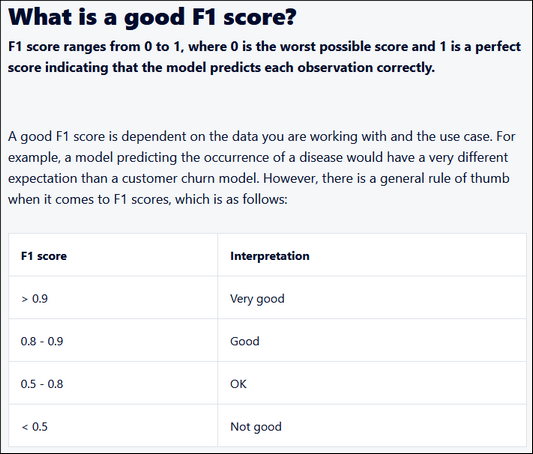


Информация по определению `f1 score` из https://stephenallwright.com/good-f1-score/

In [153]:
# сравнение метрик
df_metrics = DataFrame({"forest":[precision_forest, recall_forest, f1_score_forest],
                        "gbc":[precision_gbc, recall_gbc, f1_score_gbc],
                        "logistic":[precision_logistic, recall_logistic, f1_score_logistic],
                        "kn":[precision_kn, recall_kn, f1_score_kn],
                        "gnb":[precision_gnb, recall_gnb, f1_score_gnb],
                        "tree":[precision_tree, recall_tree, f1_score_tree],
                        "svc":[precision_svc, recall_svc, f1_score_svc],
                        "LGBM":[precision_LGBM, recall_LGBM, f1_score_LGBM],
                        "XGB":[precision_xgb, recall_xgb, f1_score_xgb],
                        "CatBoost":[precision_cat, recall_cat, f1_score_cat],                        
                        },
                        index=["precision", "recall", "f1_score"])
df_metrics

forest     gbc  logistic      kn     gnb    tree     svc    LGBM  \
precision 0.72000 0.71622   0.57500 0.35000 0.29698 0.46199 0.69663 0.59821   
recall    0.28723 0.28191   0.36702 0.18617 0.68085 0.42021 0.32979 0.35638   
f1_score  0.41065 0.40458   0.44805 0.24306 0.41357 0.44011 0.44765 0.44667   

              XGB  CatBoost  
precision 0.67708   0.67816  
recall    0.34574   0.31383  
f1_score  0.45775   0.42909

In [154]:
# проверка наибольшего значения 'f1_score'
df_metrics.T.sort_values(by="f1_score", ascending=False).f1_score.round(1)

XGB        0.50000
logistic   0.40000
svc        0.40000
LGBM       0.40000
tree       0.40000
CatBoost   0.40000
gnb        0.40000
forest     0.40000
gbc        0.40000
kn         0.20000
Name: f1_score, dtype: float64

In [183]:
# определение максимального значение метрики минимального порога
df_metrics.T[df_metrics.T.sort_values(by="f1_score", ascending=False).f1_score.round(1) >= 0.5].round(1)

C:\Users\Alina_2\AppData\Local\Temp\ipykernel_18864\1477900733.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_metrics.T[df_metrics.T.sort_values(by="f1_score", ascending=False).f1_score.round(1) >= 0.5].round(1)


precision  recall  f1_score
XGB    0.70000 0.30000   0.50000

In [155]:
# сортировка по 'f1_score'
df_metrics.T.sort_values(by="f1_score", ascending=False)

precision  recall  f1_score
XGB         0.67708 0.34574   0.45775
logistic    0.57500 0.36702   0.44805
svc         0.69663 0.32979   0.44765
LGBM        0.59821 0.35638   0.44667
tree        0.46199 0.42021   0.44011
CatBoost    0.67816 0.31383   0.42909
gnb         0.29698 0.68085   0.41357
forest      0.72000 0.28723   0.41065
gbc         0.71622 0.28191   0.40458
kn          0.35000 0.18617   0.24306

In [156]:
# сортировка по 'precision'
df_metrics.T.sort_values(by="precision", ascending=False)

precision  recall  f1_score
forest      0.72000 0.28723   0.41065
gbc         0.71622 0.28191   0.40458
svc         0.69663 0.32979   0.44765
CatBoost    0.67816 0.31383   0.42909
XGB         0.67708 0.34574   0.45775
LGBM        0.59821 0.35638   0.44667
logistic    0.57500 0.36702   0.44805
tree        0.46199 0.42021   0.44011
kn          0.35000 0.18617   0.24306
gnb         0.29698 0.68085   0.41357

In [157]:
# сортировка по 'recall'
df_metrics.T.sort_values(by="recall", ascending=False)

precision  recall  f1_score
gnb         0.29698 0.68085   0.41357
tree        0.46199 0.42021   0.44011
logistic    0.57500 0.36702   0.44805
LGBM        0.59821 0.35638   0.44667
XGB         0.67708 0.34574   0.45775
svc         0.69663 0.32979   0.44765
CatBoost    0.67816 0.31383   0.42909
forest      0.72000 0.28723   0.41065
gbc         0.71622 0.28191   0.40458
kn          0.35000 0.18617   0.24306

#### **2.9. ВИЗУАЛИЗАЦИЯ**

##### **2.9.1. Общее измениение метрик относительно модели**

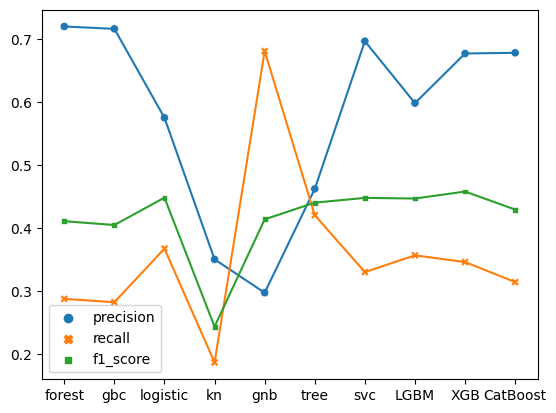

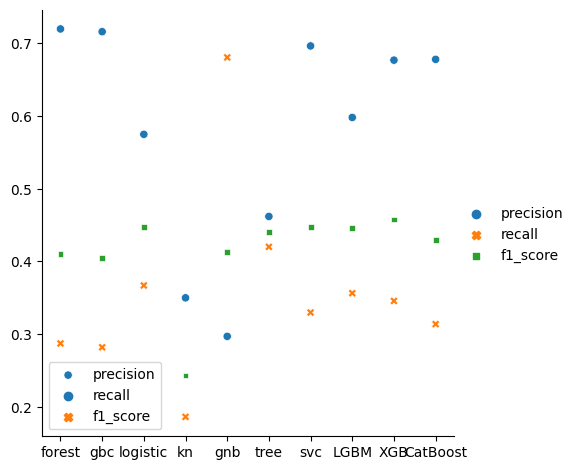

In [158]:
fig, axs = plt.subplots();
axs.plot(df_metrics.T);
sns.scatterplot(df_metrics.T);
sns.relplot(df_metrics.T);
plt.legend(df_metrics.T.columns);


##### **2.9.2. Динамика метрик моделей**

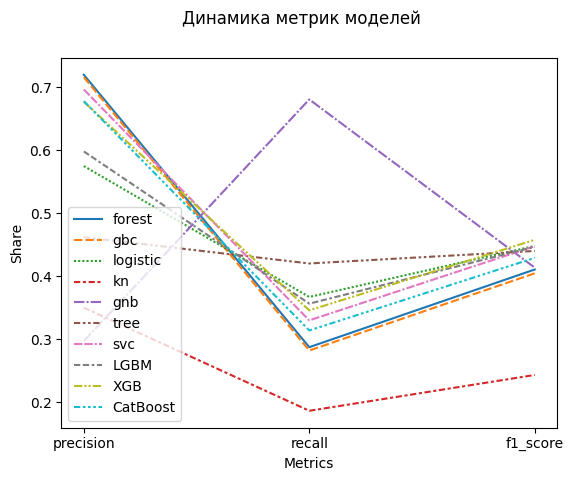

In [159]:
sns.lineplot(df_metrics);
plt.suptitle("Динамика метрик моделей");
plt.xlabel("Metrics");
plt.ylabel("Share");

## **РЕЗЮМЕ**

Все модели показали плохие результаты предсказаний одобрение кредита "credit_default" при стандартных настройках (f1_score < 0.4).

При изменении стандартных параметров у наилучших моделей при стандартных настройках есть небольшое улучшение в показателях f1_score, приближенное к 0.5. При округлении значений f1_score одна из моделей достигла удовлетворительного результата.

Представленный вариант моделей - наилучший из примерно 10 вариантов компановки параметров внутри столбца (параметра) тренировочной метрики.

**f1_score**

**Наилучшая** модель `XGB`.
**Наихужшие** показатели у `Gradient Boosting` и `K-Nearest Neighbors`.

***
**precision**


Определение TP (precision) **лучшее** у модели `Random Forest`
**Наихужшие** показатели у `Naive Bayes`.

***

**recall**


Классификация только TP.
**Наилучшие** показатели у модели `Naive Bayes`.
**Хуже** всего проявила себя модель `K-Nearest Neighbors`

***

## **ВЫВОД**
Качество предсказаний всех моделей можно попытаться улучшить пересмотром тренировочной выборки, доведя её до равного распределения между количеством позиций, у которых значение 'credit_default' (0 и 1) будет в равном отношении (сейчас это примерно 70/30).

На данный момент рекомендаций использовать модели в реальных предсказаниях нет.